In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import folium
from haversine import haversine, Unit
from geopy.geocoders import Nominatim
from folium.plugins import MarkerCluster
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
%matplotlib inline

# 관련 라이브러리 임포트 
import matplotlib.font_manager as fm

#  한글글꼴로 변경
# plt.rcParams['font.family'] = '한글글꼴명'
plt.rcParams['font.size'] = 22.0
# plt.rcParams['font.family'] = 'batang'
plt.rcParams['font.family'] = 'Malgun Gothic'

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
matplotlib.rcParams['axes.unicode_minus'] = False

# 그래프 기본 크기 설정 
plt.rcParams['figure.figsize'] = [20, 6]

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('data/29번 파일용 조정된 데이터.xlsx')
del df['Unnamed: 0']

In [3]:
df.drop(['건축년도18/1','건축년도.1','건축년도.2','건축년도18/4','건축년도.4','건축년도.5','건축년도.6','건축년도.7','건축년도.8','건축년도.9','건축년도.10','건축년도.11','건축년도.12','건축년도.13','건축년도.14','건축년도.15','건축년도.16','건축년도.17'], axis=1, inplace=True)
df.columns

Index(['ID', '거래금액(만원)_18/1', '주택금융가능여부18/1', '등락율18/1', '전세가율18/1',
       '전용면적18/1', '건물나이18/1', '거래금액(만원)_18/2', '주택금융가능여부18/2', '등락율18/2',
       ...
       '승강기당세대수', '세대당주차수', '지하주차비율', '세대당cctv수', '개별난방TF', '중앙난방TF', '지역난방TF',
       '관리시설수', '위도', '경도'],
      dtype='object', length=122)

In [4]:
df.dropna(inplace=True)

In [5]:
where = df.iloc[:,120:122]
print(where)
gongtong = df.iloc[:,109:120]
print(gongtong)

             위도          경도
2     37.487868  127.068988
3     37.487868  127.068988
4     37.488481  127.072502
5     37.488481  127.072502
6     37.488481  127.072502
...         ...         ...
4083  37.604124  127.082326
4084  37.594222  127.075432
4088  37.595961  127.080314
4089  37.595961  127.080314
4090  37.595961  127.080314

[3295 rows x 2 columns]
      거래허가제TF     세대수    관리원당세대수    승강기당세대수    세대당주차수    지하주차비율  세대당cctv수  \
2         0.0   940.0  24.736842  10.329670  0.693617  0.000000  0.058511   
3         0.0   940.0  24.736842  10.329670  0.693617  0.000000  0.058511   
4         0.0  1060.0  26.500000  10.291262  1.037736  0.000000  0.035849   
5         0.0  1060.0  26.500000  10.291262  1.037736  0.000000  0.035849   
6         0.0  1060.0  26.500000  10.291262  1.037736  0.000000  0.035849   
...       ...     ...        ...        ...       ...       ...       ...   
4083      0.0   156.0  19.500000   6.240000  0.461538  0.000000  0.147436   
4084      0.0   103.0  

In [6]:
dic = {}
num = 1

for i1 in range(1,19):
    dic[f'data{i1}'] = df.iloc[:,num:num+6]
    dic[f'data{i1}'] = pd.concat([dic[f'data{i1}'],gongtong], axis=1)
    num += 6

dic['data1']

,거래금액(만원)_18/1,주택금융가능여부18/1,등락율18/1,전세가율18/1,전용면적18/1,건물나이18/1,거래허가제TF,세대수,관리원당세대수,승강기당세대수,세대당주차수,지하주차비율,세대당cctv수,개별난방TF,중앙난방TF,지역난방TF,관리시설수
2,136666.7,0,0.000000,31.2,60,35.0,0.0,940.0,24.736842,10.329670,0.693617,0.000000,0.058511,0.0,0.0,1.0,5.0
3,177416.7,0,0.000000,25.4,80,35.0,0.0,940.0,24.736842,10.329670,0.693617,0.000000,0.058511,0.0,0.0,1.0,5.0
4,125900.0,0,9.134234,30.1,50,35.0,0.0,1060.0,26.500000,10.291262,1.037736,0.000000,0.035849,0.0,0.0,1.0,3.0
5,135200.0,0,9.023669,31.8,60,35.0,0.0,1060.0,26.500000,10.291262,1.037736,0.000000,0.035849,0.0,0.0,1.0,3.0
6,151500.0,0,10.451045,33.2,70,35.0,0.0,1060.0,26.500000,10.291262,1.037736,0.000000,0.035849,0.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4083,36300.0,1,13.223140,35.8,80,27.0,0.0,156.0,19.500000,6.240000,0.461538,0.000000,0.147436,1.0,0.0,0.0,4.0
4084,44000.0,1,0.000000,85.2,80,8.0,0.0,103.0,6.058824,2.452381,1.708738,1.000000,0.504854,1.0,0.0,0.0,4.0
4088,31756.2,1,0.000000,77.4,50,21.0,0.0,1544.0,35.090909,13.310345,0.970855,0.683122,0.103627,1.0,0.0,0.0,5.0
4089,36534.6,1,2.996064,76.9,60,20.9,0.0,1544.0,35.090909,13.310345,0.970855,0.683122,0.103627,1.0,0.0,0.0,5.0


In [7]:
dic['data18']

,거래금액(만원)_22/2,주택금융가능여부22/2,등락율22/2,전세가율22/2,전용면적22/2,건물나이22/2,거래허가제TF,세대수,관리원당세대수,승강기당세대수,세대당주차수,지하주차비율,세대당cctv수,개별난방TF,중앙난방TF,지역난방TF,관리시설수
2,202800.0,0,0.0,21.8,60,39.0,0.0,940.0,24.736842,10.329670,0.693617,0.000000,0.058511,0.0,0.0,1.0,5.0
3,282250.0,0,0.0,22.1,80,39.0,0.0,940.0,24.736842,10.329670,0.693617,0.000000,0.058511,0.0,0.0,1.0,5.0
4,189000.0,0,0.0,22.8,50,39.0,0.0,1060.0,26.500000,10.291262,1.037736,0.000000,0.035849,0.0,0.0,1.0,3.0
5,181000.0,0,0.0,21.7,60,39.0,0.0,1060.0,26.500000,10.291262,1.037736,0.000000,0.035849,0.0,0.0,1.0,3.0
6,270000.0,0,0.0,21.2,70,39.0,0.0,1060.0,26.500000,10.291262,1.037736,0.000000,0.035849,0.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4083,56933.3,1,0.0,83.4,80,31.0,0.0,156.0,19.500000,6.240000,0.461538,0.000000,0.147436,1.0,0.0,0.0,4.0
4084,78800.0,0,0.0,44.4,80,12.0,0.0,103.0,6.058824,2.452381,1.708738,1.000000,0.504854,1.0,0.0,0.0,4.0
4088,70000.0,0,0.0,52.9,50,25.0,0.0,1544.0,35.090909,13.310345,0.970855,0.683122,0.103627,1.0,0.0,0.0,5.0
4089,73000.0,0,0.0,49.5,60,24.9,0.0,1544.0,35.090909,13.310345,0.970855,0.683122,0.103627,1.0,0.0,0.0,5.0


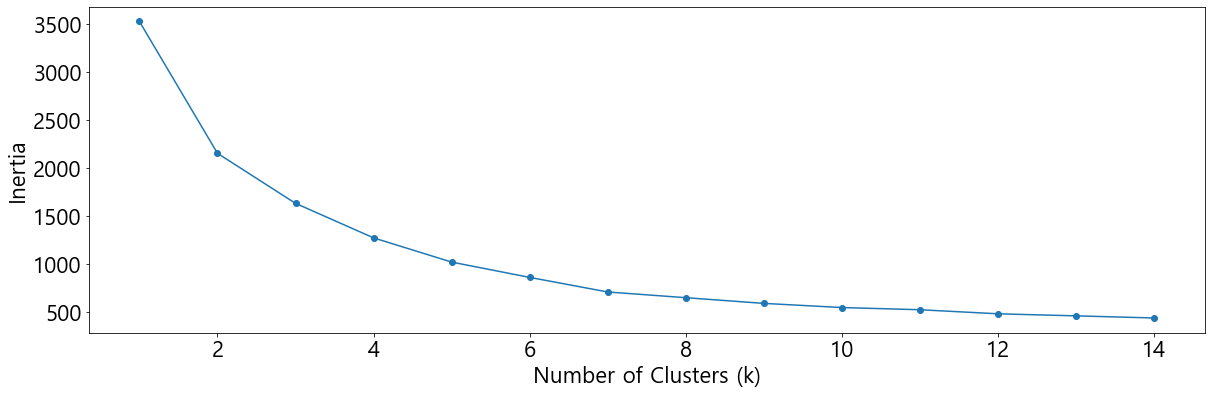

In [8]:
mm = MinMaxScaler()
mm_scaled = mm.fit_transform(dic['data1'])
samples = pd.DataFrame(mm_scaled)

num_clusters = list(range(1, 15))
inertias = []

for i in num_clusters:
    model = KMeans(n_clusters=i)
    model.fit(samples)
    inertias.append(model.inertia_)

plt.plot(num_clusters, inertias, '-o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [10]:
# 스케일링과 클러스터링
mm = MinMaxScaler()
mm_scaled1 = mm.fit_transform(dic['data1'])
mm_scaled2 = mm.fit_transform(dic['data2'])
mm_scaled3 = mm.fit_transform(dic['data3'])
mm_scaled4 = mm.fit_transform(dic['data4'])
mm_scaled5 = mm.fit_transform(dic['data5'])
mm_scaled6 = mm.fit_transform(dic['data6'])
mm_scaled7 = mm.fit_transform(dic['data7'])
mm_scaled8 = mm.fit_transform(dic['data8'])
mm_scaled9 = mm.fit_transform(dic['data9'])
mm_scaled10 = mm.fit_transform(dic['data10'])
mm_scaled11 = mm.fit_transform(dic['data11'])
mm_scaled12 = mm.fit_transform(dic['data12'])
mm_scaled13 = mm.fit_transform(dic['data13'])
mm_scaled14 = mm.fit_transform(dic['data14'])
mm_scaled15 = mm.fit_transform(dic['data15'])
mm_scaled16 = mm.fit_transform(dic['data16'])
mm_scaled17 = mm.fit_transform(dic['data17'])
mm_scaled18 = mm.fit_transform(dic['data18'])

kmeans = KMeans(n_clusters=6, init='k-means++', random_state=np.random.RandomState(seed=1))

clusters1 = kmeans.fit(mm_scaled1)
dic['data1']['cluster'] = clusters1.labels_
clusters2 = kmeans.predict(mm_scaled2)
dic['data2']['cluster'] = clusters2
clusters3 = kmeans.predict(mm_scaled3)
dic['data3']['cluster'] = clusters3
clusters4 = kmeans.predict(mm_scaled4)
dic['data4']['cluster'] = clusters4
clusters5 = kmeans.predict(mm_scaled5)
dic['data5']['cluster'] = clusters5
clusters6 = kmeans.predict(mm_scaled6)
dic['data6']['cluster'] = clusters6
clusters7 = kmeans.predict(mm_scaled7)
dic['data7']['cluster'] = clusters7
clusters8 = kmeans.predict(mm_scaled8)
dic['data8']['cluster'] = clusters8
clusters9 = kmeans.predict(mm_scaled9)
dic['data9']['cluster'] = clusters9
clusters10 = kmeans.predict(mm_scaled10)
dic['data10']['cluster'] = clusters10
clusters11 = kmeans.predict(mm_scaled11)
dic['data11']['cluster'] = clusters11
clusters12 = kmeans.predict(mm_scaled12)
dic['data12']['cluster'] = clusters12
clusters13 = kmeans.predict(mm_scaled13)
dic['data13']['cluster'] = clusters13
clusters14 = kmeans.predict(mm_scaled14)
dic['data14']['cluster'] = clusters14
clusters15 = kmeans.predict(mm_scaled15)
dic['data15']['cluster'] = clusters15
clusters16 = kmeans.predict(mm_scaled16)
dic['data16']['cluster'] = clusters16
clusters17 = kmeans.predict(mm_scaled17)
dic['data17']['cluster'] = clusters17
clusters18 = kmeans.predict(mm_scaled18)
dic['data18']['cluster'] = clusters18

In [11]:
dic['data1'].groupby('cluster').count()

,거래금액(만원)_18/1,주택금융가능여부18/1,등락율18/1,전세가율18/1,전용면적18/1,건물나이18/1,거래허가제TF,세대수,관리원당세대수,승강기당세대수,세대당주차수,지하주차비율,세대당cctv수,개별난방TF,중앙난방TF,지역난방TF,관리시설수
cluster,,,,,,,,,,,,,,,,,
0,365,365,365,365,365,365,365,365,365,365,365,365,365,365,365,365,365
1,712,712,712,712,712,712,712,712,712,712,712,712,712,712,712,712,712
2,346,346,346,346,346,346,346,346,346,346,346,346,346,346,346,346,346
3,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089
4,564,564,564,564,564,564,564,564,564,564,564,564,564,564,564,564,564
5,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219


In [12]:
dic['data9'].groupby('cluster').count()

,거래금액(만원)_20/1,주택금융가능여부20/1,등락율20/1,전세가율20/1,전용면적20/1,건물나이20/1,거래허가제TF,세대수,관리원당세대수,승강기당세대수,세대당주차수,지하주차비율,세대당cctv수,개별난방TF,중앙난방TF,지역난방TF,관리시설수
cluster,,,,,,,,,,,,,,,,,
0,262,262,262,262,262,262,262,262,262,262,262,262,262,262,262,262,262
1,1318,1318,1318,1318,1318,1318,1318,1318,1318,1318,1318,1318,1318,1318,1318,1318,1318
2,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212
3,586,586,586,586,586,586,586,586,586,586,586,586,586,586,586,586,586
4,698,698,698,698,698,698,698,698,698,698,698,698,698,698,698,698,698
5,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219


In [13]:
dic['data18'].groupby('cluster').count()

,거래금액(만원)_22/2,주택금융가능여부22/2,등락율22/2,전세가율22/2,전용면적22/2,건물나이22/2,거래허가제TF,세대수,관리원당세대수,승강기당세대수,세대당주차수,지하주차비율,세대당cctv수,개별난방TF,중앙난방TF,지역난방TF,관리시설수
cluster,,,,,,,,,,,,,,,,,
0,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90
1,1916,1916,1916,1916,1916,1916,1916,1916,1916,1916,1916,1916,1916,1916,1916,1916,1916
2,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71
3,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159
4,838,838,838,838,838,838,838,838,838,838,838,838,838,838,838,838,838
5,221,221,221,221,221,221,221,221,221,221,221,221,221,221,221,221,221


In [14]:
data1 = dic['data1'].groupby(['cluster','주택금융가능여부18/1']).count().iloc[:,1:2]
data2 = dic['data2'].groupby(['cluster','주택금융가능여부18/2']).count().iloc[:,1:2]
data3 = dic['data3'].groupby(['cluster','주택금융가능여부18/3']).count().iloc[:,1:2]
data4 = dic['data4'].groupby(['cluster','주택금융가능여부18/4']).count().iloc[:,1:2]
data5 = dic['data5'].groupby(['cluster','주택금융가능여부19/1']).count().iloc[:,1:2]
data6 = dic['data6'].groupby(['cluster','주택금융가능여부19/2']).count().iloc[:,1:2]
data7 = dic['data7'].groupby(['cluster','주택금융가능여부19/3']).count().iloc[:,1:2]
data8 = dic['data8'].groupby(['cluster','주택금융가능여부19/4']).count().iloc[:,1:2]
data9 = dic['data9'].groupby(['cluster','주택금융가능여부20/1']).count().iloc[:,1:2]
data10 = dic['data10'].groupby(['cluster','주택금융가능여부20/2']).count().iloc[:,1:2]
data11 = dic['data11'].groupby(['cluster','주택금융가능여부20/3']).count().iloc[:,1:2]
data12 = dic['data12'].groupby(['cluster','주택금융가능여부20/4']).count().iloc[:,1:2]
data13 = dic['data13'].groupby(['cluster','주택금융가능여부21/1']).count().iloc[:,1:2]
data14 = dic['data14'].groupby(['cluster','주택금융가능여부21/2']).count().iloc[:,1:2]
data15 = dic['data15'].groupby(['cluster','주택금융가능여부21/3']).count().iloc[:,1:2]
data16 = dic['data16'].groupby(['cluster','주택금융가능여부21/4']).count().iloc[:,1:2]
data17 = dic['data17'].groupby(['cluster','주택금융가능여부22/1']).count().iloc[:,1:2]
data18 = dic['data18'].groupby(['cluster','주택금융가능여부22/2']).count().iloc[:,1:2]

In [15]:
data1

등락율18/1
cluster 주택금융가능여부18/1         
0       1                 365
1       0                 712
2       1                 346
3       1                1089
4       0                 564
5       0                 121
        1                  98

In [16]:
total = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10, data11, data12, data13, data14, data15, data16, data17, data18], axis=1)
total

등락율18/1  등락율18/2  등락율18/3  등락율18/4  등락율19/1  등락율19/2  등락율19/3  \
cluster                                                                    
0       0      NaN      NaN      NaN      NaN      NaN      NaN        1   
        1    365.0    358.0    330.0    320.0    324.0    321.0      309   
1       0    712.0    785.0    945.0   1007.0    999.0   1005.0     1084   
2       1    346.0    321.0    284.0    276.0    278.0    274.0      257   
3       1   1089.0   1023.0    891.0    839.0    843.0    840.0      772   
4       0    564.0    589.0    626.0    634.0    632.0    636.0      653   
5       0    121.0    129.0    142.0    150.0    150.0    149.0      155   
        1     98.0     90.0     77.0     69.0     69.0     70.0       64   

           등락율19/4  등락율20/1  등락율20/2  등락율20/3  등락율20/4  등락율21/1  등락율21/2  \
cluster                                                                    
0       0        1        3        1      NaN        1        4        2   
        1      287      259      239    204.0      171      148      119   
1       0     1196     1318     1427   1565.0     1687     1759     1820   
2       1      235      212      187    159.0      143      125       95   
3       1      682      586      499    397.0      306      254      224   
4       0      675      698      723    751.0      768      786      815   
5       0      160      164      168    178.0      179      186      191   
        1       59       55       51     41.0       40       33       29   

           등락율21/3  등락율21/4  등락율22/1  등락율22/2  
cluster                                        
0       0      NaN        5        5        2  
        1     93.0       89       89       88  
1       0   1903.0     1916     1916     1916  
2       1     72.0       69       74       71  
3       1    169.0      155      155      159  
4       0    837.0      840      835      838  
5       0    196.0      197      197      198  
        1     25.0       24       24       23

In [19]:
data1 = dic['data1'].groupby(['cluster','지역난방TF']).count().iloc[:,1:2]
data2 = dic['data2'].groupby(['cluster','지역난방TF']).count().iloc[:,1:2]
data3 = dic['data3'].groupby(['cluster','지역난방TF']).count().iloc[:,1:2]
data4 = dic['data4'].groupby(['cluster','지역난방TF']).count().iloc[:,1:2]
data5 = dic['data5'].groupby(['cluster','지역난방TF']).count().iloc[:,1:2]
data6 = dic['data6'].groupby(['cluster','지역난방TF']).count().iloc[:,1:2]
data7 = dic['data7'].groupby(['cluster','지역난방TF']).count().iloc[:,1:2]
data8 = dic['data8'].groupby(['cluster','지역난방TF']).count().iloc[:,1:2]
data9 = dic['data9'].groupby(['cluster','지역난방TF']).count().iloc[:,1:2]
data10 = dic['data10'].groupby(['cluster','지역난방TF']).count().iloc[:,1:2]
data11 = dic['data11'].groupby(['cluster','지역난방TF']).count().iloc[:,1:2]
data12 = dic['data12'].groupby(['cluster','지역난방TF']).count().iloc[:,1:2]
data13 = dic['data13'].groupby(['cluster','지역난방TF']).count().iloc[:,1:2]
data14 = dic['data14'].groupby(['cluster','지역난방TF']).count().iloc[:,1:2]
data15 = dic['data15'].groupby(['cluster','지역난방TF']).count().iloc[:,1:2]
data16 = dic['data16'].groupby(['cluster','지역난방TF']).count().iloc[:,1:2]
data17 = dic['data17'].groupby(['cluster','지역난방TF']).count().iloc[:,1:2]
data18 = dic['data18'].groupby(['cluster','지역난방TF']).count().iloc[:,1:2]

In [20]:
total = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10, data11, data12, data13, data14, data15, data16, data17, data18], axis=1)
total

주택금융가능여부18/1  주택금융가능여부18/2  주택금융가능여부18/3  주택금융가능여부18/4  \
cluster 지역난방TF                                                           
0       0.0            365.0         358.0         330.0         320.0   
1       0.0            712.0         785.0         945.0        1007.0   
2       0.0              6.0           6.0           6.0           6.0   
        1.0            340.0         315.0         278.0         270.0   
3       0.0           1089.0        1023.0         891.0         839.0   
4       0.0              NaN           NaN           NaN           NaN   
        1.0            564.0         589.0         626.0         634.0   
5       0.0            219.0         219.0         219.0         219.0   

                주택금융가능여부19/1  주택금융가능여부19/2  주택금융가능여부19/3  주택금융가능여부19/4  \
cluster 지역난방TF                                                           
0       0.0            324.0         321.0         310.0         288.0   
1       0.0            999.0        1005.0        1084.0        1196.0   
2       0.0              6.0           6.0           6.0           6.0   
        1.0            272.0         268.0         251.0         229.0   
3       0.0            843.0         840.0         772.0         682.0   
4       0.0              NaN           NaN           NaN           NaN   
        1.0            632.0         636.0         653.0         675.0   
5       0.0            219.0         219.0         219.0         219.0   

                주택금융가능여부20/1  주택금융가능여부20/2  주택금융가능여부20/3  주택금융가능여부20/4  \
cluster 지역난방TF                                                           
0       0.0            262.0         240.0         204.0           172   
1       0.0           1318.0        1427.0        1565.0          1687   
2       0.0              6.0           6.0           6.0             6   
        1.0            206.0         181.0         153.0           137   
3       0.0            586.0         499.0         397.0           306   
4       0.0              NaN           NaN           NaN             1   
        1.0            698.0         723.0         751.0           767   
5       0.0            219.0         219.0         219.0           219   

                주택금융가능여부21/1  주택금융가능여부21/2  주택금융가능여부21/3  주택금융가능여부21/4  \
cluster 지역난방TF                                                           
0       0.0              152           121            93            94   
1       0.0             1759          1820          1903          1916   
2       0.0                6             5             4             4   
        1.0              119            90            68            65   
3       0.0              254           224           169           155   
4       0.0                1             1             1             1   
        1.0              785           814           836           839   
5       0.0              219           220           221           221   

                주택금융가능여부22/1  주택금융가능여부22/2  
cluster 지역난방TF                              
0       0.0               94            90  
1       0.0             1916          1916  
2       0.0                4             4  
        1.0               70            67  
3       0.0              155           159  
4       0.0                1             1  
        1.0              834           837  
5       0.0              221           221

In [21]:
data1 = dic['data1'].groupby(['cluster','중앙난방TF']).count().iloc[:,1:2]
data2 = dic['data2'].groupby(['cluster','중앙난방TF']).count().iloc[:,1:2]
data3 = dic['data3'].groupby(['cluster','중앙난방TF']).count().iloc[:,1:2]
data4 = dic['data4'].groupby(['cluster','중앙난방TF']).count().iloc[:,1:2]
data5 = dic['data5'].groupby(['cluster','중앙난방TF']).count().iloc[:,1:2]
data6 = dic['data6'].groupby(['cluster','중앙난방TF']).count().iloc[:,1:2]
data7 = dic['data7'].groupby(['cluster','중앙난방TF']).count().iloc[:,1:2]
data8 = dic['data8'].groupby(['cluster','중앙난방TF']).count().iloc[:,1:2]
data9 = dic['data9'].groupby(['cluster','중앙난방TF']).count().iloc[:,1:2]
data10 = dic['data10'].groupby(['cluster','중앙난방TF']).count().iloc[:,1:2]
data11 = dic['data11'].groupby(['cluster','중앙난방TF']).count().iloc[:,1:2]
data12 = dic['data12'].groupby(['cluster','중앙난방TF']).count().iloc[:,1:2]
data13 = dic['data13'].groupby(['cluster','중앙난방TF']).count().iloc[:,1:2]
data14 = dic['data14'].groupby(['cluster','중앙난방TF']).count().iloc[:,1:2]
data15 = dic['data15'].groupby(['cluster','중앙난방TF']).count().iloc[:,1:2]
data16 = dic['data16'].groupby(['cluster','중앙난방TF']).count().iloc[:,1:2]
data17 = dic['data17'].groupby(['cluster','중앙난방TF']).count().iloc[:,1:2]
data18 = dic['data18'].groupby(['cluster','중앙난방TF']).count().iloc[:,1:2]

In [22]:
total = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10, data11, data12, data13, data14, data15, data16, data17, data18], axis=1)
total

주택금융가능여부18/1  주택금융가능여부18/2  주택금융가능여부18/3  주택금융가능여부18/4  \
cluster 중앙난방TF                                                           
0       0.0              365           358           330           320   
1       0.0              712           785           945          1007   
2       0.0              346           321           284           276   
3       0.0             1089          1023           891           839   
4       0.0              564           589           626           634   
5       0.0                1             1             1             1   
        1.0              218           218           218           218   

                주택금융가능여부19/1  주택금융가능여부19/2  주택금융가능여부19/3  주택금융가능여부19/4  \
cluster 중앙난방TF                                                           
0       0.0              324           321           310           288   
1       0.0              999          1005          1084          1196   
2       0.0              278           274           257           235   
3       0.0              843           840           772           682   
4       0.0              632           636           653           675   
5       0.0                1             1             1             1   
        1.0              218           218           218           218   

                주택금융가능여부20/1  주택금융가능여부20/2  주택금융가능여부20/3  주택금융가능여부20/4  \
cluster 중앙난방TF                                                           
0       0.0              262           240           204           172   
1       0.0             1318          1427          1565          1687   
2       0.0              212           187           159           143   
3       0.0              586           499           397           306   
4       0.0              698           723           751           768   
5       0.0                1             1             1             1   
        1.0              218           218           218           218   

                주택금융가능여부21/1  주택금융가능여부21/2  주택금융가능여부21/3  주택금융가능여부21/4  \
cluster 중앙난방TF                                                           
0       0.0              152           121            93            94   
1       0.0             1759          1820          1903          1916   
2       0.0              125            95            72            69   
3       0.0              254           224           169           155   
4       0.0              786           815           837           840   
5       0.0                1             2             3             3   
        1.0              218           218           218           218   

                주택금융가능여부22/1  주택금융가능여부22/2  
cluster 중앙난방TF                              
0       0.0               94            90  
1       0.0             1916          1916  
2       0.0               74            71  
3       0.0              155           159  
4       0.0              835           838  
5       0.0                3             3  
        1.0              218           218